# Data Science Regression Project: Melanoma Tumor Size Prediction


## Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

# Data Load: Melanoma Tumor Size into a dataframe

In [21]:
train = pd.read_csv(r'E:/Data_Sets/Train_15.csv')
test  = pd.read_csv(r'E:/Data_Sets/Test_15.csv')

In [22]:
train.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


In [23]:
train.describe()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
count,9146.000000,9146.000000,9146.000000,9146.000000,9.146000e+03,9146.000000,9146.000000,9146.000000,9146.000000,9146.000000
mean,9903.052174,3032.827837,0.303083,103.902118,1.372442e+06,146.304239,3992.936256,69.849661,34.461652,7.723348
std,4060.577116,1462.334147,0.062533,55.456862,5.646773e+05,70.512177,1780.672859,55.785332,5.972808,6.086852
min,2864.760000,510.530000,0.114820,10.310100,3.878534e+05,31.970400,1089.190000,0.000000,15.228000,0.000000
25%,6988.420000,1983.657500,0.259053,64.012525,9.596873e+05,95.853900,3177.682500,31.000000,30.290225,2.320000
50%,8895.965000,2684.330000,0.301055,88.458300,1.237057e+06,126.138500,3846.320000,54.000000,35.245750,5.060500
75%,12119.950000,3830.745000,0.343002,134.209000,1.693083e+06,182.251500,4664.577500,91.000000,38.806075,13.336000
max,36995.400000,13535.000000,0.525300,346.420000,4.978616e+06,528.890000,91983.700000,340.000000,46.546400,20.999000


In [24]:
target = train.pop('tumor_size')

## Transformation 

In [25]:
train['exposed_area'] = np.log1p(train['exposed_area'])

test['exposed_area'] = np.log1p(test['exposed_area'])

# Feature Engineering

## Deriving new columns from the existing in order to have more information available for the model to learn so that it can perform with better accuracy

In [33]:
train['penalty-err'] = train['malign_penalty'] - train['err_malign']
train['d_size-ratio'] = train['damage_size'] - train['damage_ratio']
train['d_ratio-m_ratio'] = train['damage_ratio'] - (train['malign_ratio'])
train['penalty/std'] = train['malign_penalty']/train['std_dev_malign']
train['mass/area'] = (train['mass_npea'])/(train['exposed_area'])
train['area/mass'] = train['exposed_area']/train['mass_npea']
train['err/std'] = train['penalty-err']/train['std_dev_malign']
train['dsr/ps'] = train['damage_size']/train['penalty-err']
train['std/area'] = train['std_dev_malign']/train['exposed_area']
train['err/area'] = train['err_malign']/train['exposed_area']
train['dr/area'] = (train['damage_ratio']*100)/train['exposed_area']
train['std/err'] = (train['std_dev_malign']+1)/(train['err_malign']+1)
train['penalty/err'] = (train['malign_penalty']+1)/(train['err_malign']+1)

test['penalty-err'] = test['malign_penalty'] - test['err_malign']
test['d_size-ratio'] = test['damage_size'] - test['damage_ratio']
test['d_ratio-m_ratio'] = test['damage_ratio'] - (test['malign_ratio'])
test['penalty/std'] = test['malign_penalty']/test['std_dev_malign']
test['mass/area'] = (test['mass_npea'])/(test['exposed_area'])
test['area/mass'] = test['exposed_area']/test['mass_npea']
test['err/std'] = test['penalty-err']/test['std_dev_malign']
test['dsr/ps'] = test['damage_size']/test['penalty-err']
test['std/area'] = test['std_dev_malign']/test['exposed_area']
test['err/area'] = test['err_malign']/test['exposed_area']
test['dr/area'] = (test['damage_ratio']*100)/test['exposed_area']
test['std/err'] = (test['std_dev_malign']+1)/(test['err_malign']+1)
test['penalty/err'] = (test['malign_penalty']+1)/(test['err_malign']+1)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9146 entries, 0 to 9145
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mass_npea        9146 non-null   float64
 1   size_npear       9146 non-null   float64
 2   malign_ratio     9146 non-null   float64
 3   damage_size      9146 non-null   float64
 4   exposed_area     9146 non-null   float64
 5   std_dev_malign   9146 non-null   float64
 6   err_malign       9146 non-null   float64
 7   malign_penalty   9146 non-null   int64  
 8   damage_ratio     9146 non-null   float64
 9   penalty-err      9146 non-null   float64
 10  d_size-ratio     9146 non-null   float64
 11  d_ratio-m_ratio  9146 non-null   float64
 12  penalty/std      9146 non-null   float64
 13  mass/area        9146 non-null   float64
 14  area/mass        9146 non-null   float64
 15  err/std          9146 non-null   float64
 16  dsr/ps           9146 non-null   float64
 17  std/area      

## Defining Metric

In [6]:
def RMSE(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
rmse = make_scorer(RMSE, greater_is_better=False)

## Hyperparameter tuning of Extratrees Regressor using Bayesian optimization

In [7]:
def etc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = ExtraTreesRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=2,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [8]:
def optimize_etc(data, target):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                max_features=max(min(max_features, 0.999), 1e-3),
                data=data,
                target=target,
                )
    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators":(100,400),
            "min_samples_split":(2,25),
            "max_features": (0.1,0.9)
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [35]:
print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(train, target)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -4.092    |  0.3996   |  23.87    |  319.6    |
|  2        | -3.817    |  0.5789   |  5.588    |  146.8    |
|  3        | -4.192    |  0.1465   |  21.92    |  280.3    |
|  4        | -3.779    |  0.6665   |  2.473    |  391.0    |
|  5        | -3.83     |  0.766    |  6.884    |  154.5    |
|  6        | -4.066    |  0.9      |  25.0     |  100.0    |
|  7        | -3.772    |  0.3464   |  2.026    |  392.3    |
|  8        | -4.331    |  0.1      |  25.0     |  400.0    |
|  9        | -4.333    |  0.1      |  25.0     |  145.0    |
|  10       | -3.789    |  0.7983   |  2.0      |  171.4    |
|  11       | -3.787    |  0.4474   |  2.0      |  189.9    |
|  12       | -4.014    |  0.9      |  20.98    |  187.0    |
|  13       | -3.863    |  0.1      |  2.0      |  209.9    |
|  14       | -3.857    |  0.1      |  

In [36]:
etc = ExtraTreesRegressor(n_estimators=int(392.3242333129391),
                         min_samples_split=int(2.0259434886125725),
                         max_features=0.34640819636969217,
                         n_jobs = -1,
                         random_state = 42)

## Hyperparameter tuning of RandomForest Regressor using Bayesian optimization

In [29]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [30]:
def optimize_rfc(data, target):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.9), 1e-3),
            data=data,
            target=target,
            )
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators":(100,500),
            "min_samples_split":(2,25),
            "max_features":(0.1,0.9),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)
    
    print("Final result:", optimizer.max)

In [37]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(train, target)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -4.044    |  0.2532   |  16.31    |  275.1    |
|  2        | -4.098    |  0.7283   |  19.94    |  209.0    |
|  3        | -4.074    |  0.3212   |  20.44    |  483.3    |
|  4        | -4.022    |  0.8007   |  10.23    |  300.4    |
|  5        | -4.077    |  0.6468   |  18.39    |  248.1    |
|  6        | -4.037    |  0.549    |  13.57    |  105.5    |
|  7        | -4.117    |  0.7183   |  22.3     |  246.0    |
|  8        | -3.947    |  0.5923   |  3.734    |  247.5    |
|  9        | -4.077    |  0.8465   |  16.98    |  258.9    |
|  10       | -4.015    |  0.731    |  9.287    |  327.2    |
|  11       | -3.924    |  0.1662   |  2.0      |  243.5    |
|  12       | -3.977    |  0.9      |  2.0      |  232.8    |
|  13       | -4.193    |  0.1      |  25.0     |  349.8    |
|  14       | -3.976    |  0.7313   |

In [38]:
rfc = RandomForestRegressor(n_estimators = int(421.6986461274645),
                           min_samples_split=int(2.4893231506864923),
                           max_features = 0.41013558840105446,
                           n_jobs = -1, 
                           random_state = 42)

## Hyperparameter tuning of LightGradientBoosting Regressor using Bayesian optimization

In [46]:
def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, target):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [47]:
def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves= int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            target=target,
        )
    
    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators":(100,500),
            "num_leaves":(30,90),
            "min_child_samples":(5,30),
            "subsample":(0.6,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=20)
    
    print("Final result:", optimizer.max)

In [48]:
print(Colours.blue("--- Optimizing Light GBM ---"))
optimize_lgb(train, target)

--- Optimizing Light GBM ---
|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -3.98     |  9.788    |  348.8    |  56.26    |  0.9141   |
|  2        | -4.015    |  24.5     |  209.0    |  46.59    |  0.9207   |
|  3        | -3.982    |  28.95    |  450.4    |  51.47    |  0.8004   |
|  4        | -3.986    |  22.09    |  385.1    |  52.22    |  0.8245   |
|  5        | -4.024    |  17.58    |  105.5    |  76.37    |  0.9531   |
|  6        | -4.019    |  14.12    |  346.2    |  34.52    |  0.7475   |
|  7        | -3.993    |  28.33    |  360.6    |  53.83    |  0.9155   |
|  8        | -3.972    |  12.92    |  327.2    |  82.15    |  0.7745   |
|  9        | -3.995    |  25.05    |  157.5    |  72.26    |  0.8818   |
|  10       | -3.972    |  10.47    |  469.9    |  56.53    |  0.9637   |
|  11       | -4.078    |  6.495    |  173.7    |  32.84    |  0.87     |
|  12    

In [49]:
lgb = LGBMRegressor(
        n_estimators=int(490.23543329860655),
        num_leaves = int(65.78052355195761),
        min_child_samples=int(5.0),
        subsample = 0.6,
        random_state = 42
    )

## Hyperparameter tuning of ExtremeGradientBoosting Regressor using Bayesian optimization

In [51]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, target):
    estimator = XGBRegressor(
            n_estimators=n_estimators,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [54]:
def optimize_xgb(data, target):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            target=target,
        )
    optimizer = BayesianOptimization(
            f=xgb_crossval,
            pbounds={
                "n_estimators":(150,500),
                "max_depth": (1,20),
                "gamma":(0,10),
                "min_child_weight":(0,10),
                "subsample":(0.8,1.0)
                },
            random_state=1234,
            verbose=2
      )
    optimizer.maximize(n_iter=15 , init_points=10)
    
    
    print('Final Result:', optimizer.max)

In [55]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(train, target)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.244    |  1.915    |  12.82    |  4.377    |  424.9    |  0.956    |
|  2        | -4.252    |  2.726    |  6.253    |  8.019    |  485.3    |  0.9752   |
|  3        | -4.3      |  3.578    |  10.52    |  6.835    |  399.4    |  0.8741   |
|  4        | -4.245    |  5.612    |  10.56    |  0.1377   |  420.5    |  0.9765   |
|  5        | -4.226    |  3.649    |  12.69    |  0.7538   |  279.1    |  0.9866   |
|  6        | -4.233    |  6.514    |  8.547    |  7.887    |  260.9    |  0.9136   |
|  7        | -4.186    |  8.691    |  9.287    |  8.021    |  200.3    |  0.9409   |
|  8        | -4.203    |  7.046    |  5.157    |  9.249    |  304.7    |  0.9819   |
|  9        | -4.241    |  0.5981   |  4.501    |  0.4736   |  386.2    |  0.9189   |
|  10       | -4.219    |  

In [58]:
xgb = XGBRegressor(
        n_estimators=int(200.3183885800976),
        max_depth = int(9.287295054017909),
        gamma = 8.691273895612259,
        min_child_weight = 8.02147642080159,
        subsample = 0.9408521942236671,
        random_state = 42,
    )

## Hyperparameter tuning of ExtremeGradientBoosting and RandomForest Regressor using Bayesian optimization

In [79]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [82]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [83]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(train, target)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.197    |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
|  2        | -4.504    |  2.726    |  8.488    |  8.019    |  487.4    |  0.9752   |
|  3        | -4.265    |  3.578    |  10.51    |  6.835    |  413.8    |  0.8741   |
|  4        | -4.287    |  5.612    |  10.53    |  0.1377   |  431.8    |  0.9765   |
|  5        | -4.228    |  3.649    |  11.54    |  0.7538   |  310.6    |  0.9866   |
|  6        | -4.364    |  6.514    |  9.575    |  7.887    |  295.1    |  0.9136   |
|  7        | -4.381    |  8.691    |  9.926    |  8.021    |  243.1    |  0.9409   |
|  8        | -4.643    |  7.046    |  7.969    |  9.249    |  332.6    |  0.9819   |
|  9        | -4.605    |  0.5981   |  7.659    |  0.4736   |  402.5    |  0.9189   |
|  10       | 

In [84]:
xgbrf = XGBRFRegressor(
        n_estimators=int(284.6733469057235),
        max_depth = int(15.0),
        gamma = 8.16966206019828,
        min_child_weight=0.0,
        subsample = 0.8,
        random_state = 42,
    )

## Stacking all the models 

In [85]:
estimators = [('etc', etc), ('rfc', rfc), ('xgb', xgb), ('lgb', lgb), ('xgbrf', xgbrf)]

model = StackingRegressor(estimators=estimators)

In [87]:
scores = cross_val_score(model, train, target, cv = 5, scoring = rmse)

scores

array([-3.57868487, -3.62815384, -3.8190788 , -3.77845183, -3.72005502])

In [88]:
scores.mean()

-3.704884871290338

## Checking the model performance by ploting the Learning Curve

In [96]:
from sklearn.model_selection import learning_curve
x_train = train.values
y_train = target.values

In [100]:
train_sizes, train_scores, valid_scores = learning_curve(
model , x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 6), scoring='neg_root_mean_squared_error', cv=5)

In [101]:
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean valid scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 73      3.336721
1521    1.389713
2970    1.520303
4418    1.429074
5867    1.369761
7316    1.303635
dtype: float64

 --------------------

Mean valid scores

 73      5.669373
1521    4.242629
2970    3.990072
4418    3.900751
5867    3.784567
7316    3.703136
dtype: float64


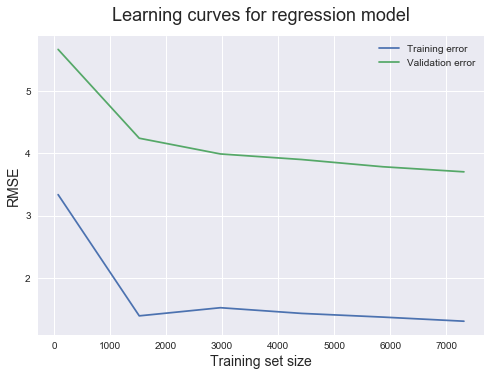

In [102]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model', fontsize = 18, y = 1.03)
plt.legend()

## The Model Accuracy(RMSE) is 3.704